In [2]:
import numpy as np
import matplotlib.pyplot as plt
from utilis import *

In [21]:
min_val = np.quantile(S[-1], 0.01)  # 1st percentile
max_val = np.quantile(S[-1], 0.99)  # 99th percentile

## My version

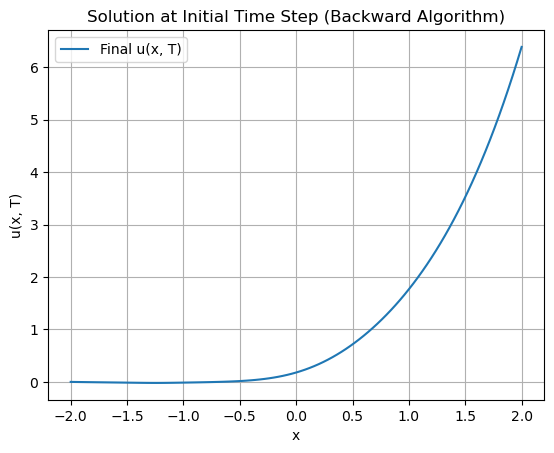

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded

# Parameters
r = 0.05        # Risk-free rate
sigma = 0.4     # Volatility
K = 1.0         # Strike price
T = 1.0         # Expiry time
lambda_ = 0.005 # Temperature constant
Nx = 100        # Number of space steps
Nt = 100        # Number of time steps

# Space discretization
x_min, x_max = -2, 2  # Domain for x
x = np.linspace(x_min, x_max, Nx+1)
dx = (x_max - x_min) / Nx

# Time discretization
dt = T / Nt
t = np.linspace(0, T, Nt+1)

# Construct L_x matrix coefficients
a = 0.5 * sigma**2 / dx**2 - (r - 0.5 * sigma**2) / (2 * dx)  # Lower diagonal
b = -sigma**2 / dx**2 - r  # Main diagonal
c = 0.5 * sigma**2 / dx**2 + (r - 0.5 * sigma**2) / (2 * dx)  # Upper diagonal

# Banded matrix for efficient solving
A_banded = np.zeros((3, Nx-1))
A_banded[0, 1:] = c  # Upper diagonal
A_banded[1, :] = 1/dt - b  # Main diagonal (implicit time step)
A_banded[2, :-1] = a  # Lower diagonal

# Initial condition (final condition for backward in time)
h = np.maximum(-K+np.exp(x) , 0)  # Example: Call option-like function
nu = h.copy()

# Newton iteration parameters
tol = 1e-6
max_iter = 50
damping = 0.5  # Damping factor for Newton updates

# Time stepping (backward in time)
for n in reversed(range(Nt)):
    u_old = nu.copy()
    for k in range(max_iter):  # Newton iteration
        f = (u_old[1:-1] - nu[1:-1]) / dt \
            - (a * u_old[:-2] + b * u_old[1:-1] + c * u_old[2:]) \
            + lambda_ * np.exp(-(u_old[1:-1] - h[1:-1]) / lambda_)
        
        df = 1 / dt - b - (1 / lambda_) * lambda_ * np.exp(-(u_old[1:-1] - h[1:-1]) / lambda_)
        
        du = -f / df
        
        # Apply damping to avoid divergence
        u_old[1:-1] += damping * du
        
        if np.any(np.isnan(u_old)):
            print("NaN encountered! Stopping.")
            break
        
        if np.linalg.norm(du) < tol:
            break
    nu = u_old.copy()

# Plot final function
plt.plot(x, nu, label='Final u(x, T)')
plt.xlabel("x")
plt.ylabel("u(x, T)")
plt.title("Solution at Initial Time Step (Backward Algorithm)")
plt.legend()
plt.grid()
plt.show()

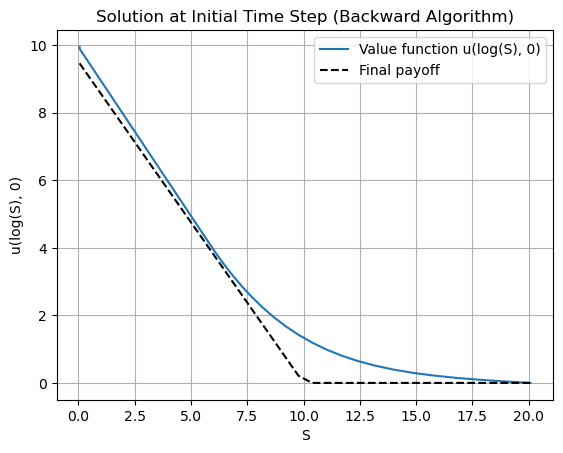

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded


# Parameters
r = 0.05        # Risk-free rate
sigma = 0.4     # Volatility
K = 10.0         # Strike price
T = 1.0         # Expiry time
lambda_ = 0.05 # Temperature constant
Nx = 100        # Number of space steps
Nt = 100        # Number of time steps

# Space discretization
x_min, x_max = -3, 3  # Domain for x
x = np.linspace(x_min, x_max, Nx+1)
dx = (x_max - x_min) / Nx

# Time discretization
dt = T / Nt
t = np.linspace(0, T, Nt+1)

# Construct L_x matrix coefficients
a = 0.5 * sigma**2 / dx**2 - (r - 0.5 * sigma**2) / (2 * dx)  # Lower diagonal
b = -sigma**2 / dx**2 - r  # Main diagonal
c = 0.5 * sigma**2 / dx**2 + (r - 0.5 * sigma**2) / (2 * dx)  # Upper diagonal

# Banded matrix for efficient solving
A_banded = np.zeros((3, Nx-1))
A_banded[0, 1:] = c  # Upper diagonal
A_banded[1, :] = 1/dt - b  # Main diagonal (implicit time step)
A_banded[2, :-1] = a  # Lower diagonal

# Initial condition (final condition for backward in time)
eps = 1e-6  # Small value to prevent numerical issues
h = np.maximum(K - np.exp(x), eps)  # Put option-like function
nu = h.copy()

# Newton iteration parameters
tol = 1e-6
max_iter = 50
damping = 0.5  # Damping factor for Newton updates

# Time stepping (backward in time)
for n in reversed(range(Nt)):
    u_old = nu.copy()
    for k in range(max_iter):  # Newton iteration
        u_old = np.maximum(u_old, h - lambda_)  # Prevent instability
        
        f = (u_old[1:-1] - nu[1:-1]) / dt \
            - (a * u_old[:-2] + b * u_old[1:-1] + c * u_old[2:]) \
            + lambda_ * np.exp(-(u_old[1:-1] - h[1:-1]) / lambda_)
        
        df = 1 / dt - b - (1 / lambda_) * lambda_ * np.exp(-(u_old[1:-1] - h[1:-1]) / lambda_)
        
        du = -f / df
        
        # Apply damping to avoid divergence
        u_old[1:-1] += damping * du
        
        if np.any(np.isnan(u_old)):
            print("NaN encountered! Stopping.")
            break
        
        if np.linalg.norm(du) < tol:
            break
    nu = u_old.copy()

# Plot final function
plt.plot(np.exp(x), nu, label='Value function u(log(S), 0)')
plt.plot(np.exp(x),np.exp(-r*T)*np.maximum(K-np.exp(x),0), label = 'Final payoff', linestyle='dashed',color = 'Black')
plt.xlabel("S")
plt.ylabel("u(log(S), 0)")
plt.title("Solution at Initial Time Step (Backward Algorithm)")
plt.legend()
plt.grid()
plt.show()


### Using a full solver 

In [4]:
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Time stepping (backward in time)
for n in reversed(range(Nt)):
    u_old = nu.copy()
    for k in range(max_iter):  # Newton iteration
        u_old = np.maximum(u_old, h - lambda_)  # Prevent instability
        
        # Compute f(u) (residual)
        f = (u_old[1:-1] - nu[1:-1]) / dt \
            - (a * u_old[:-2] + b * u_old[1:-1] + c * u_old[2:]) \
            + lambda_ * np.exp(-(u_old[1:-1] - h[1:-1]) / lambda_)

        # Compute the Jacobian J(u)
        d_main = 1 / dt - b - np.exp(-(u_old[1:-1] - h[1:-1]) / lambda_)  # Main diagonal
        d_lower = -a * np.ones(Nx-2)  # Lower diagonal
        d_upper = -c * np.ones(Nx-2)  # Upper diagonal
        
        # Construct sparse tridiagonal Jacobian matrix
        J = diags([d_lower, d_main, d_upper], offsets=[-1, 0, 1], format='csc')

        # Solve for du: J * du = -f
        du = spsolve(J, -f)

        # Apply damping to ensure stability
        u_old[1:-1] += damping * du

        # Check for NaN or convergence
        if np.any(np.isnan(u_old)):
            print("NaN encountered! Stopping.")
            break
        if np.linalg.norm(du) < tol:
            break

    nu = u_old.copy()


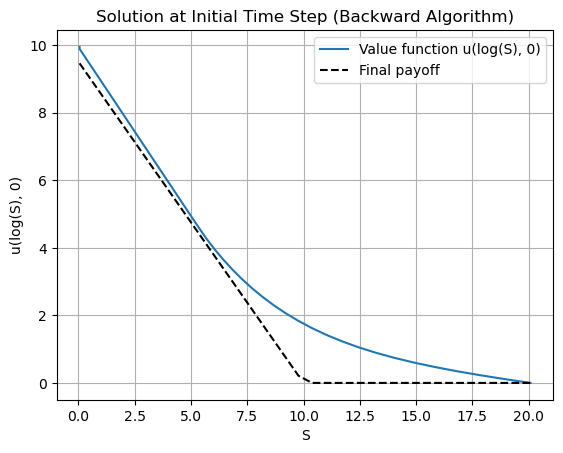

In [5]:
# Plot final function
plt.plot(np.exp(x), nu, label='Value function u(log(S), 0)')
plt.plot(np.exp(x),np.exp(-r*T)*np.maximum(K-np.exp(x),0), label = 'Final payoff', linestyle='dashed',color = 'Black')
plt.xlabel("S")
plt.ylabel("u(log(S), 0)")
plt.title("Solution at Initial Time Step (Backward Algorithm)")
plt.legend()
plt.grid()
plt.show()

### Pricing americain option 

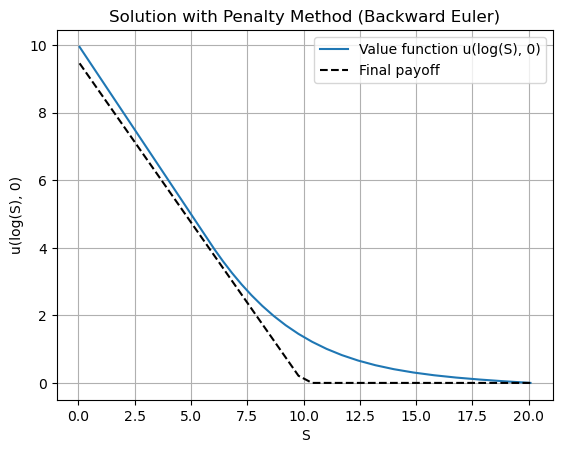

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Parameters
r = 0.05        # Risk-free rate
sigma = 0.4     # Volatility
K = 10.0        # Strike price
T = 1.0         # Expiry time
lambda_ = 100   # Penalty parameter (should be large)
Nx = 100        # Number of space steps
Nt = 100        # Number of time steps

# Space discretization
x_min, x_max = -3, 3  # Domain for x
x = np.linspace(x_min, x_max, Nx+1)
dx = (x_max - x_min) / Nx

# Time discretization
dt = T / Nt
t = np.linspace(0, T, Nt+1)

# Construct L_x matrix coefficients
a = 0.5 * sigma**2 / dx**2 - (r - 0.5 * sigma**2) / (2 * dx)  # Lower diagonal
b = -sigma**2 / dx**2 - r  # Main diagonal
c = 0.5 * sigma**2 / dx**2 + (r - 0.5 * sigma**2) / (2 * dx)  # Upper diagonal

# Initial condition (final condition for backward in time)
eps = 1e-6  # Small value to prevent numerical issues
h = np.maximum(K - np.exp(x), eps)  # Payoff function (like American put)
nu = h.copy()  # Initialize with the obstacle condition

# Newton iteration parameters
tol = 1e-6
max_iter = 50
damping = 0.5  # Damping factor for Newton updates

# Time stepping (backward in time)
for n in reversed(range(Nt)):
    u_old = nu.copy()
    for k in range(max_iter):  # Newton iteration
        penalty = np.maximum(0, h[1:-1] - u_old[1:-1])  # Penalty function
        
        # Compute f(u) (residual)
        f = (u_old[1:-1] - nu[1:-1]) / dt \
            - (a * u_old[:-2] + b * u_old[1:-1] + c * u_old[2:]) \
            + lambda_ * penalty

        # Compute the Jacobian J(u)
        d_main = 1 / dt - b - lambda_ * (penalty > 0)  # Main diagonal
        d_lower = -a * np.ones(Nx-2)  # Lower diagonal
        d_upper = -c * np.ones(Nx-2)  # Upper diagonal
        
        # Construct sparse tridiagonal Jacobian matrix
        J = diags([d_lower, d_main, d_upper], offsets=[-1, 0, 1], format='csc')

        # Solve for du: J * du = -f
        du = spsolve(J, -f)

        # Apply damping to ensure stability
        u_old[1:-1] += damping * du

        # Enforce obstacle condition manually
        u_old = np.maximum(u_old, h)

        # Check for NaN or convergence
        if np.any(np.isnan(u_old)):
            print("NaN encountered! Stopping.")
            break
        if np.linalg.norm(du) < tol:
            break

    nu = u_old.copy()

# Plot final function
plt.plot(np.exp(x), nu, label='Value function u(log(S), 0)')
plt.plot(np.exp(x), np.exp(-r*T) * np.maximum(K - np.exp(x), 0), 
         label='Final payoff', linestyle='dashed', color='black')
plt.xlabel("S")
plt.ylabel("u(log(S), 0)")
plt.title("Solution with Penalty Method (Backward Euler)")
plt.legend()
plt.grid()
plt.show()
